# 4.2 Physics-Informed Neural Networks

In the physical sciences, we may already have physical models to explain observations. The fundamental principle in PINNs trains a neural network that is physis-agnostic at initial design, but constraining the predictions to obey physical law by crafting the loss function accordingly.

We will take the simple example of the heat diffusion in 1D. The tutorial below is inspired by https://github.com/TheodoreWolf/pinns.

In [20]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(10)

We write a simple PDE

$ \frac{dT}{dt} (t) = T(t) / R $,

Where $R$ is a time scale that characterize the diffusion of temperature.


As a potential solution to this equation, we write the theoretical temperature field:


$  $  



<!-- The heat equation is a diffusion equation:

$\frac{\partial T}{\partial t} (x,t) = k \frac{\partial^2 T}{\partial x^2} (x,t)$,

where $k$ is the diffusivity.  -->


First, we create synthetic, toy, noisy data.

In [131]:


def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time) #
    # return T

In [43]:
# def cooling_law(time, Tenv, T0, tau):
#     # T = Tenv + (T0 - Tenv) * scipy.special.erf(time/k)
#     T = Tenv + (T0 - Tenv) * (1 - np.exp(-time/tau))
#     return T

Make noisy synthetic data

Text(0.5, 0, 'Time (s)')

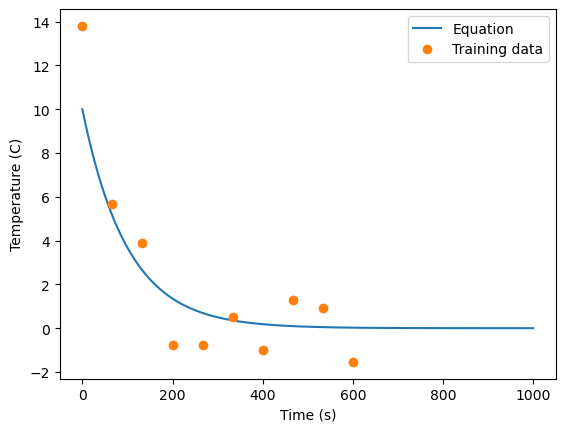

In [139]:
Tenv = 0
T0 = 10
tau = 100
R = 0.01
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R )
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Create a simple neural network

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat



def np_to_th(x): # Convert numpy array to torch tensor
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


def grad(outputs, inputs): # Compute gradient of outputs with respect to inputs
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


class Net(nn.Module):
    def __init__(
        self,
        input_dim,  # Number of input features
        output_dim, # Number of output features
        n_units=100, # Number of units in hidden layers
        epochs=1000, # Number of epochs to train for
        loss=nn.MSELoss(), # Loss function
        lr=1e-3, # Learning rate
        loss2=None, # Second loss function
        loss2_weight=0.1, # Weight of second loss function
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential( # Define layers
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x): # Forward pass
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y): # Train the model
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr) # Optimiser
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                # loss += self.loss2_weight * self.loss2(self)
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


Epoch 0/20000, loss: 45.47
Epoch 2000/20000, loss: 16.37
Epoch 4000/20000, loss: 2.13
Epoch 6000/20000, loss: 1.30
Epoch 8000/20000, loss: 1.05
Epoch 10000/20000, loss: 0.86
Epoch 12000/20000, loss: 0.76
Epoch 14000/20000, loss: 0.71
Epoch 16000/20000, loss: 0.67
Epoch 18000/20000, loss: 0.63


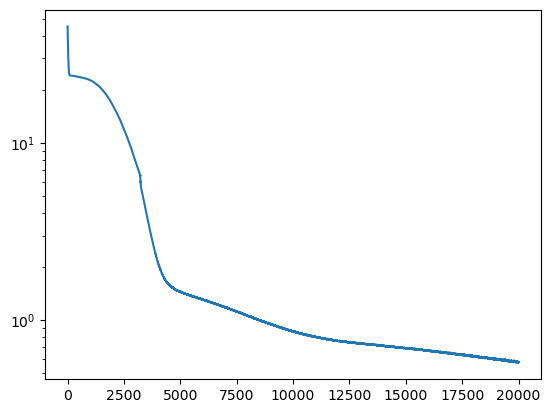

In [141]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)
losses = net.fit(t,T)


plt.plot(losses)
plt.yscale('log')

First, we will regularize the training using **Ridge Regression** of the model by adding the norm of the model weights. We first define an additional loss as the L2 norm of all hidden model parameters.

In [142]:
# define the second loss function as the L2 norm of the weights
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Re-train the model from scratch by minimizing the residual and model loss.

Epoch 0/20000, loss: 3251.90
Epoch 2000/20000, loss: 1686.80
Epoch 4000/20000, loss: 844.77
Epoch 6000/20000, loss: 366.15
Epoch 8000/20000, loss: 129.77
Epoch 10000/20000, loss: 42.80
Epoch 12000/20000, loss: 25.80
Epoch 14000/20000, loss: 25.03
Epoch 16000/20000, loss: 25.03
Epoch 18000/20000, loss: 25.03


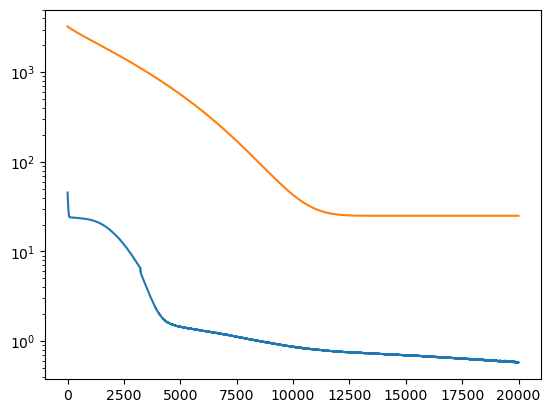

In [144]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses2 = netreg.fit(t, T)

plt.plot(losses)
plt.plot(losses2)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

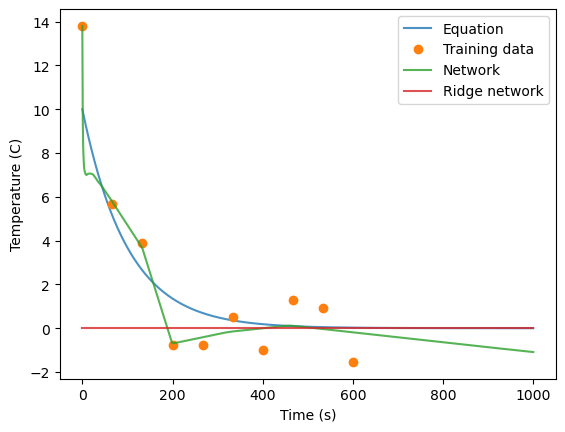

In [146]:
predsreg = netreg.predict(times)
preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'Ridge network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

## PINN

We now inform the model training by constraining the predicted output to satisfy the equation of diffusion.

The loss is defined by predicting the output fields on a synthetic time series. Caluclating such loss involves:
1. create a synthetic input series that is regularly spaced / gridded that goes from 0 to maximal value. We add the function ```requires_grad``` to allow differentiation of the model output with respect to this input field.
2. predict the output field given the synthetic input for each, sorted, input field.
3. calculate the gradient of the output, given that the output vector is created from incrementally increasing input values. 
4. calculate the residual of the PDE: dT/dt - R()


In [147]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE) # Time as torch tensor
    # require_grad=True means that we will be able to compute gradients with respect to this tensor
    temps = model(ts) # Compute temperatures on the synthetic time input
    dT = grad(temps, ts)[0] # Compute the derivative of the temperatures with respect to time
    pde = R*(Tenv - temps) - dT # compute the residual of the PDE: dT/dt - R(Tenv - T) = 0
    
    return torch.mean(pde**2)

Epoch 0/30000, loss: 26.58
Epoch 3000/30000, loss: 5.23
Epoch 6000/30000, loss: 2.07
Epoch 9000/30000, loss: 1.85
Epoch 12000/30000, loss: 1.78
Epoch 15000/30000, loss: 1.74
Epoch 18000/30000, loss: 1.68
Epoch 21000/30000, loss: 1.62
Epoch 24000/30000, loss: 1.54
Epoch 27000/30000, loss: 1.48


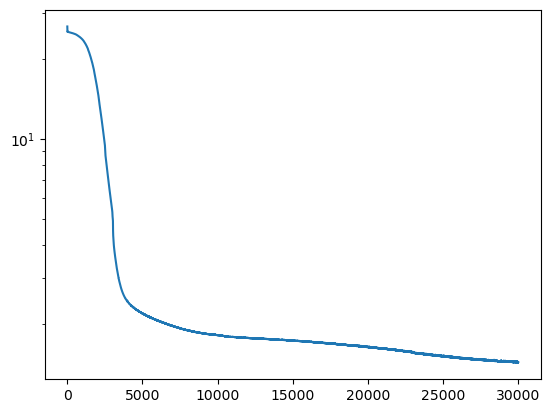

In [148]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')


Text(0.5, 0, 'Time (s)')

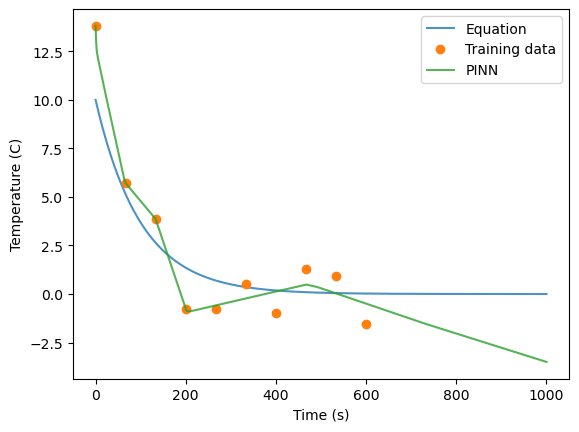

In [149]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [ ]:

class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))